In [1]:
import os # 위에껄로 대체가능
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import json
# import numpy as np
# import shap
import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow import keras
import shap

import numpy as np


In [3]:
from tensorflow.keras.utils import to_categorical

## Resnet 모델 불러오기

In [9]:
model_path='save_models'
model_file='av11_ResNet44v1_model_no_mean.093.h5'

In [10]:
model=keras.models.load_model(os.path.join(model_path, model_file))

In [19]:
x_train=np.load('x_train.npy')
x_test=np.load('x_test.npy')
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')

In [12]:
num_classes=9

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train=y_train.astype('uint8')
y_test=y_test.astype('uint8')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (90000, 32, 32, 3)
90000 train samples
27000 test samples
y_train shape: (90000, 1)


## 기타함수

In [58]:
def scaling_x(img_npy, x_train_mean=False):
    
    
    num_classes=9


    x_train = img_npy.astype('float32') / 255

    # if subtract pixel mean is enabled
    if x_train_mean:
        x_train -= x_train_mean
        
    return x_train


## 0. Error

In [9]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

## 1. DeepExplainer

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Front%20Page%20DeepExplainer%20MNIST%20Example.html

In [9]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [10]:
np.random.seed(42)

random_idx=np.random.choice(x_train.shape[0],100,replace=False)

In [12]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[random_idx]

# explain predictions of the model on three images
#e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    /home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/shap/explainers/_deep/deep_tf.py:248 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    /home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/tensorflow/python/eager/backprop.py:1086 gradient  **
        unconnected_gradients=unconnected_gradients)
    /home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/tensorflow/python/eager/imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    /home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/tensorflow/python/eager/backprop.py:151 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    /home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/tensorflow/python/framework/registry.py:99 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_FusedBatchNormV3


In [14]:
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

SyntaxError: invalid syntax (<ipython-input-14-7359da0ab1b4>, line 5)

## 2. Partition Explainer

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html

In [44]:
# load pre-trained model and data
#model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

In [18]:
# # python function to get model output; replace this function with your own model function.
def f(x):
#     tmp = x.copy()
#     preprocess_input(tmp)
    return model(x)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_ns", x_train[0].shape)

In [54]:
class_names = ['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

### 실행

In [51]:
pick_point=3

size=10

In [52]:
train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

In [55]:
full_ex_image_file_list=[]

for class_name in class_names:
    ex_image_file_list=os.listdir(os.path.join(train_dir, class_name))
    full_ex_image_file_list.append(ex_image_file_list)

In [56]:
import matplotlib.pyplot as plt

In [59]:
class_idx=1
class_name='bus'
np.random.seed(42)
index_arange=np.arange(len(full_ex_image_file_list[class_idx]))
np.random.shuffle(index_arange)
i=0
ex_images=[]
part_of_index=index_arange[size*(pick_point):size*(pick_point+1)]

for idx in part_of_index:
    ex_image=plt.imread(os.path.join(train_dir, class_name, full_ex_image_file_list[class_idx][idx]))
    ex_images.append(ex_image)
print('range(pick:{}) :'.format(pick_point), f'{size*(pick_point)} ~ {size*(pick_point+1)}')

ex_images_scaled=np.array(ex_images)
ex_images_scaled=scaling_x(ex_images_scaled)

prediction=model.predict(ex_images_scaled)
top1_class=prediction.argmax(1)


range(pick:3) : 30 ~ 40


In [74]:
shap_values[0,0:10,0:10,0:5, 0]


.values =
array([[[-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07]],

       [[-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.51690687e-07, -3.51690687e-07, -3.51690687e-07],
        [-3.

range(pick:3) : 30 ~ 40


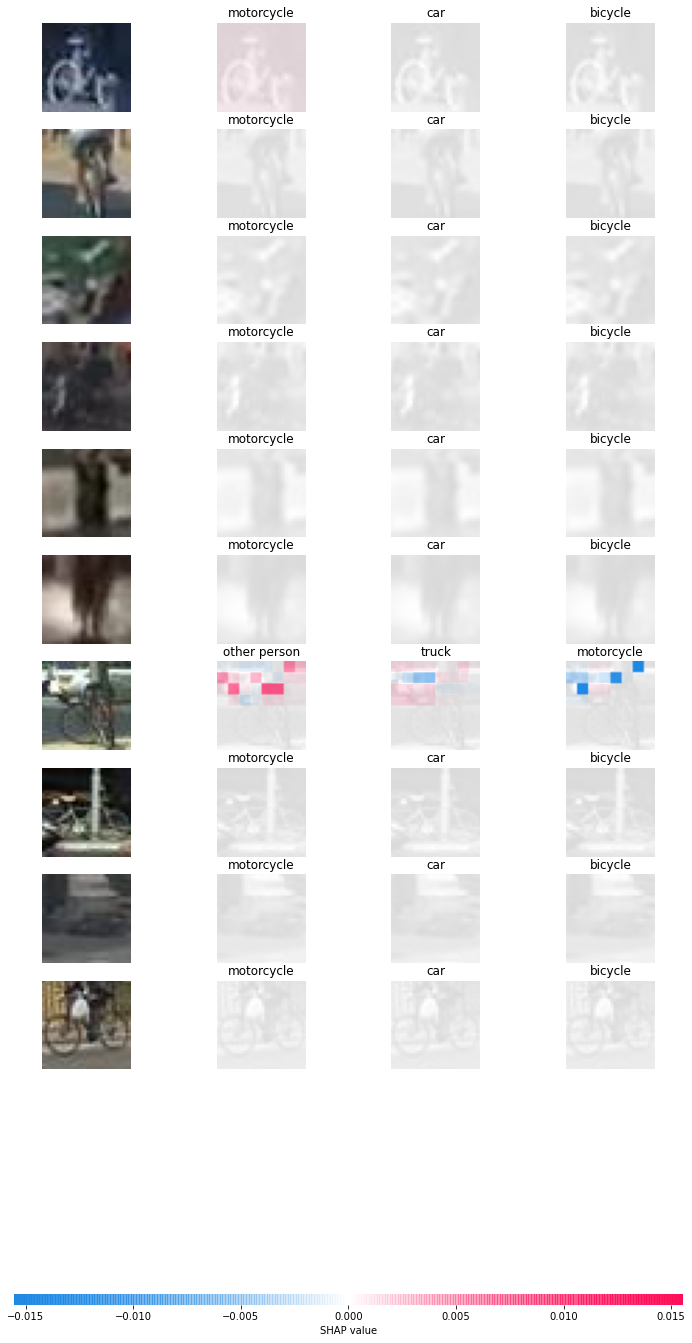

range(pick:3) : 30 ~ 40


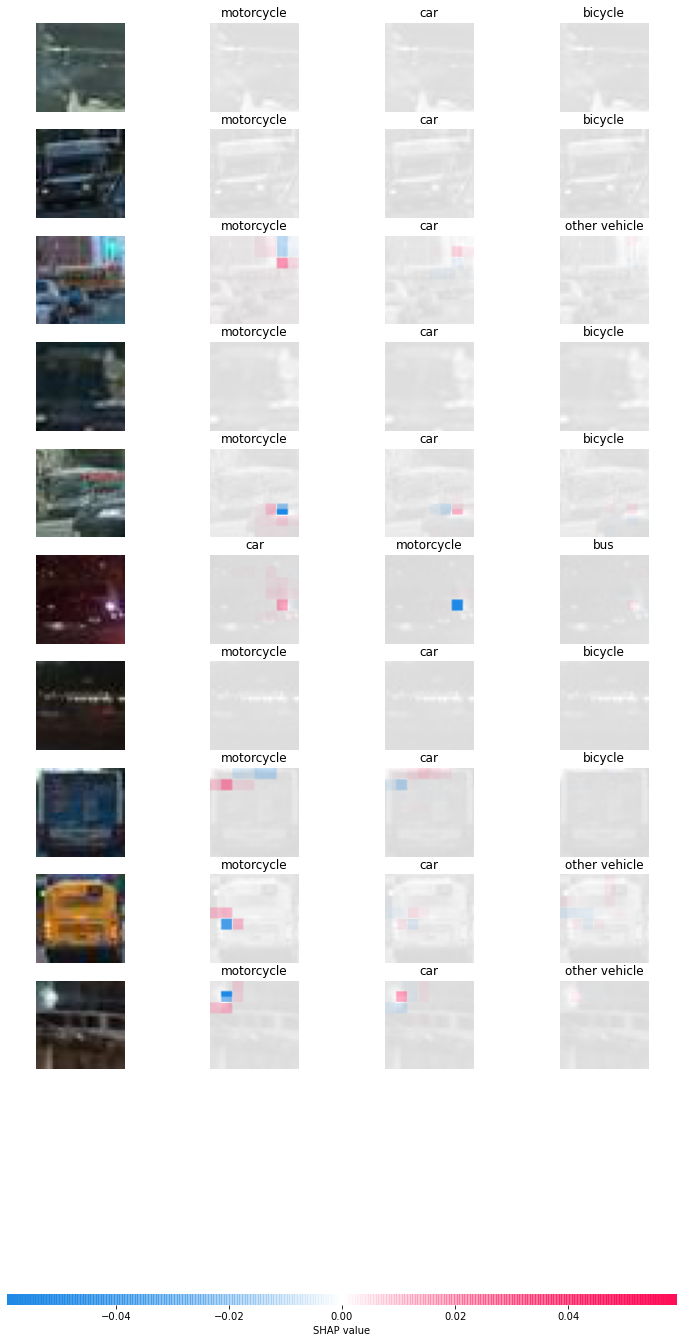

range(pick:3) : 30 ~ 40


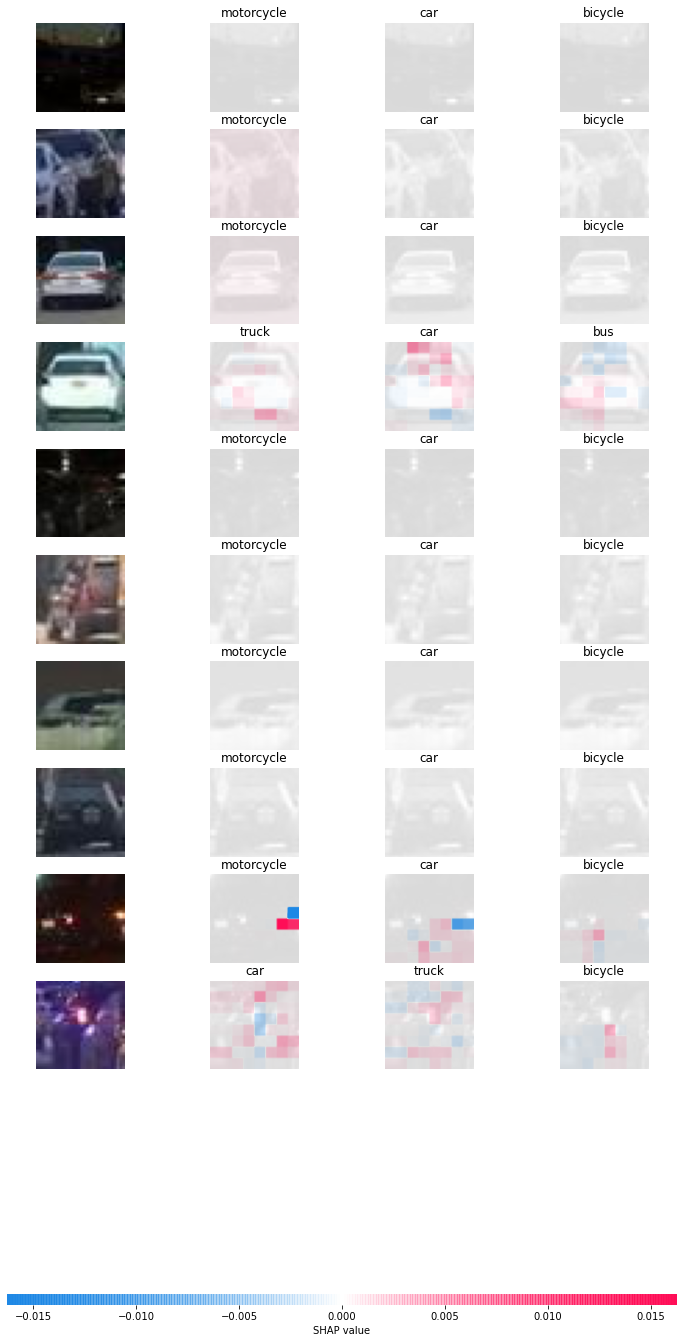

In [60]:
for class_idx,class_name in enumerate(class_names[:3]):
    np.random.seed(42)
    index_arange=np.arange(len(full_ex_image_file_list[class_idx]))
    np.random.shuffle(index_arange)
    i=0
    ex_images=[]
    part_of_index=index_arange[size*(pick_point):size*(pick_point+1)]

    for idx in part_of_index:
        ex_image=plt.imread(os.path.join(train_dir, class_name, full_ex_image_file_list[class_idx][idx]))
        ex_images.append(ex_image)
    print('range(pick:{}) :'.format(pick_point), f'{size*(pick_point)} ~ {size*(pick_point+1)}')

    ex_images_scaled=np.array(ex_images)
    ex_images_scaled=scaling_x(ex_images_scaled)

    prediction=model.predict(ex_images_scaled)
    top1_class=prediction.argmax(1)
    top1_prediction=[]
    for i, class_idx in enumerate(top1_class):
        top1_prediction.append(np.round(prediction[i][class_idx], 4))
        
        # define a masker that is used to mask out partitions of the input image.
    masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)
    explainer = shap.Explainer(f, masker, output_names=class_names)    
    shap_values = explainer(ex_images_scaled, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])
    # output with shap values
    shap.image_plot(shap_values)

### x_train

In [32]:
random_idx=np.arange(len(x_train))
np.random.shuffle(random_idx)
np.random.seed(42)


In [55]:
model_path='save_models'
model_file='av11_ResNet44v1_model_no_mean.010.h5'

In [56]:
model=keras.models.load_model(os.path.join(model_path, model_file))

In [57]:
model(x_train[random_idx[:20]]).numpy().argmax(1)

array([3, 3, 7, 4, 2, 6, 7, 0, 6, 7, 2, 7, 0, 3, 7, 3, 3, 0, 3, 8])

In [61]:
y_train[random_idx[:20]].argmax(1)

array([3, 3, 1, 4, 2, 6, 7, 0, 2, 7, 2, 7, 0, 3, 7, 3, 3, 0, 3, 8])

In [62]:
def f(x):
    tmp = x.copy()
    #preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask o partitions of the input image.
masker = shap.maskers.Image("inpaint_ns", x_train[0].shape)


explainer = shap.Explainer(model, masker, output_names=class_names)  
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(x_train[random_idx[50:90]], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

Partition explainer: 41it [00:45,  1.47s/it]                        


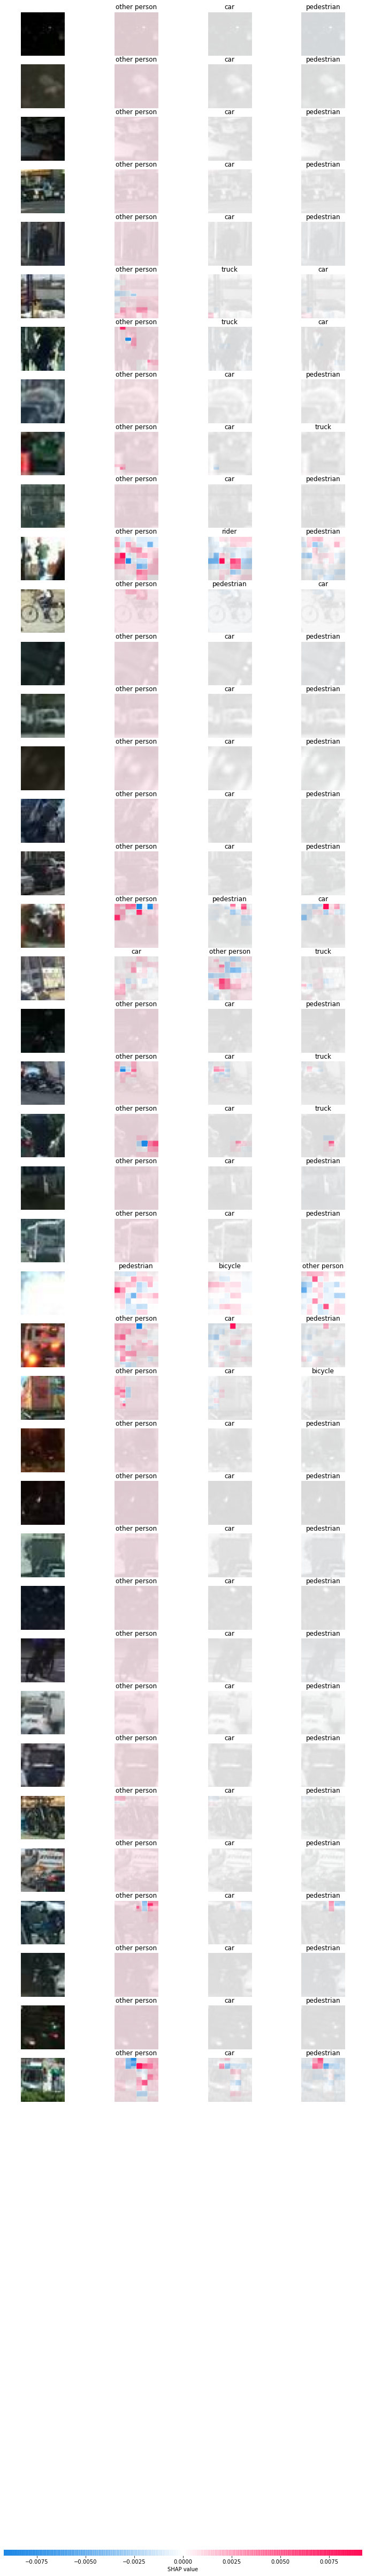

In [63]:
# output with shap values
shap.image_plot(shap_values)

In [ ]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier


# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model, x_train[:10], link="logit")
shap_values = explainer.shap_values(x_test[:50], nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], x_test.iloc[:50,:], link="logit")


## MINE

In [ ]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

## 3. Multi-class Resnet..

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Multi-class%20ResNet50%20on%20ImageNet%20%28TensorFlow%29.html

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import json
import shap
import tensorflow as tf

# load pre-trained model and choose two images to explain
model = ResNet50(weights='imagenet')
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)
X, y = shap.datasets.imagenet50()

# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

# 기타 필요 함수

In [ ]:
def get_dataset():
    train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
    test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

    batch_size = 128
    img_height = 32
    img_width = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    return train_ds, test_ds

In [ ]:
def batch_to_numpy(train_ds, test_ds):

    # av dataset
    # 0610 : 9개의 클래스에 대해 train(!0000), test(3000)
    x_train_base=np.zeros([90000, 32, 32, 3])
    y_train_base=np.zeros([90000, 1])
    x_test_base=np.zeros([27000, 32, 32, 3])
    y_test_base=np.zeros([27000, 1])

    numpy_iter=list(train_ds.as_numpy_iterator())

    for idx, batch in enumerate(numpy_iter):
    #     if idx%30==0:
    #         print(idx)
        x_train_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_train_base[128*idx:128*(idx+1), 0]=batch[1]

    numpy_iter_test=list(test_ds.as_numpy_iterator())

    len(numpy_iter_test)

    for idx, batch in enumerate(numpy_iter_test):
    #     if idx%30==0:
    #         print(idx)
        x_test_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_test_base[128*idx:128*(idx+1), 0]=batch[1]
    
    return x_train_base, y_train_base, x_test_base, y_test_base

## 대안

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [75]:
model=ResNet50(weights='imagenet')

In [76]:
X, y = shap.datasets.imagenet50()

In [77]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

In [78]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [83]:
class_n

(50, 224, 224, 3)

In [84]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_ns", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 4/50 [00:31<03:46,  4.93s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 5/50 [00:45<06:24,  8.54s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 6/50 [00:58<07:20, 10.02s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 7/50 [01:07<07:04,  9.87s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 8/50 [01:18<07:06, 10.17s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 9/50 [01:30<07:17, 10.67s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 10/50 [01:40<07:02, 10.56s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 11/50 [01:49<06:31, 10.03s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 12/50 [01:58<06:14,  9.86s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 13/50 [02:10<06:24, 10.38s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 14/50 [02:19<05:55,  9.87s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 15/50 [02:26<05:18,  9.10s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 16/50 [02:34<05:03,  8.93s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 17/50 [02:42<04:39,  8.48s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 18/50 [02:52<04:45,  8.91s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 19/50 [02:59<04:23,  8.49s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 20/50 [03:10<04:36,  9.20s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 21/50 [03:19<04:24,  9.13s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 22/50 [03:27<04:05,  8.78s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 23/50 [03:36<03:56,  8.78s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 24/50 [03:46<04:00,  9.25s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 25/50 [03:57<04:06,  9.85s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 26/50 [04:08<03:58,  9.95s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 27/50 [04:16<03:38,  9.48s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 28/50 [04:26<03:31,  9.63s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 29/50 [04:35<03:18,  9.45s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 30/50 [04:45<03:14,  9.71s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 31/50 [04:56<03:10, 10.02s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 33/50 [05:11<02:25,  8.58s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 34/50 [05:20<02:19,  8.70s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 35/50 [05:31<02:22,  9.53s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 36/50 [05:39<02:04,  8.90s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 37/50 [05:51<02:08,  9.89s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 38/50 [06:00<01:55,  9.66s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 39/50 [06:11<01:49,  9.92s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 40/50 [06:23<01:46, 10.63s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 41/50 [06:33<01:34, 10.51s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 42/50 [06:42<01:18,  9.87s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 43/50 [06:56<01:18, 11.25s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 44/50 [07:07<01:06, 11.03s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 45/50 [07:16<00:52, 10.41s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 46/50 [07:25<00:40, 10.22s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 47/50 [07:35<00:30, 10.12s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 48/50 [07:45<00:20, 10.00s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 49/50 [07:55<00:09,  9.87s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 50/50 [08:02<00:00,  9.29s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 51it [08:14, 10.08s/it]                        


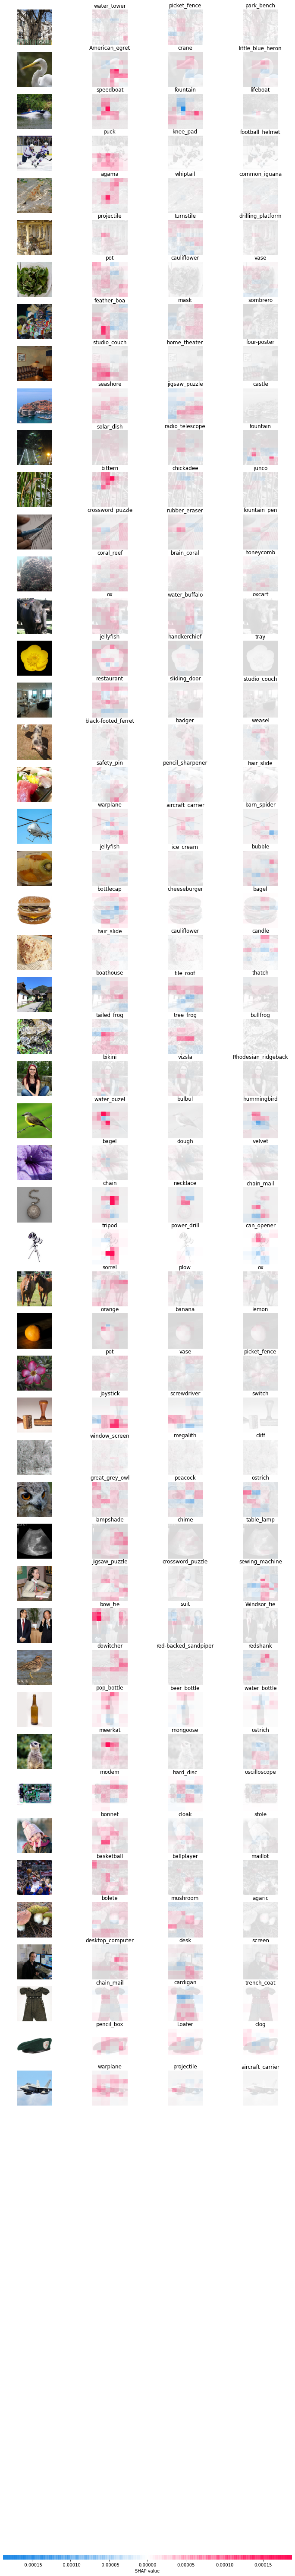

In [85]:
# output with shap values
shap.image_plot(shap_values)

In [24]:
class_names = ['bicycle','bus',
 'car',
 'other person',
 'other vehicle',
               
 'motorcycle',
 'pedestrian',
 'rider',
 'truck']

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [35]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_ns", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

Exception: The length of the image to be masked must match the shape given in the ImageMasker contructor: 224 * 224 * 3 != 32 * 32 * 3

In [46]:
class_names

['bicycle',
 'bus',
 'car',
 'other person',
 'other vehicle',
 'motorcycle',
 'pedestrian',
 'rider',
 'truck']

In [47]:
class_names = ['busEED','bicycleee',
 'car',
 'other person',
 'other vehicle',
               
 'motorcycle',
 'pedestrian',
 'rider',
 'truck']

In [48]:
def f(x):
    tmp = x.copy()
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_ns", x_train[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_valuesee = explainer(x_train[1:20], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

Partition explainer: 20it [00:15,  2.25s/it]                        


In [50]:
y_train

array([[8.],
       [0.],
       [2.],
       ...,
       [7.],
       [0.],
       [6.]])

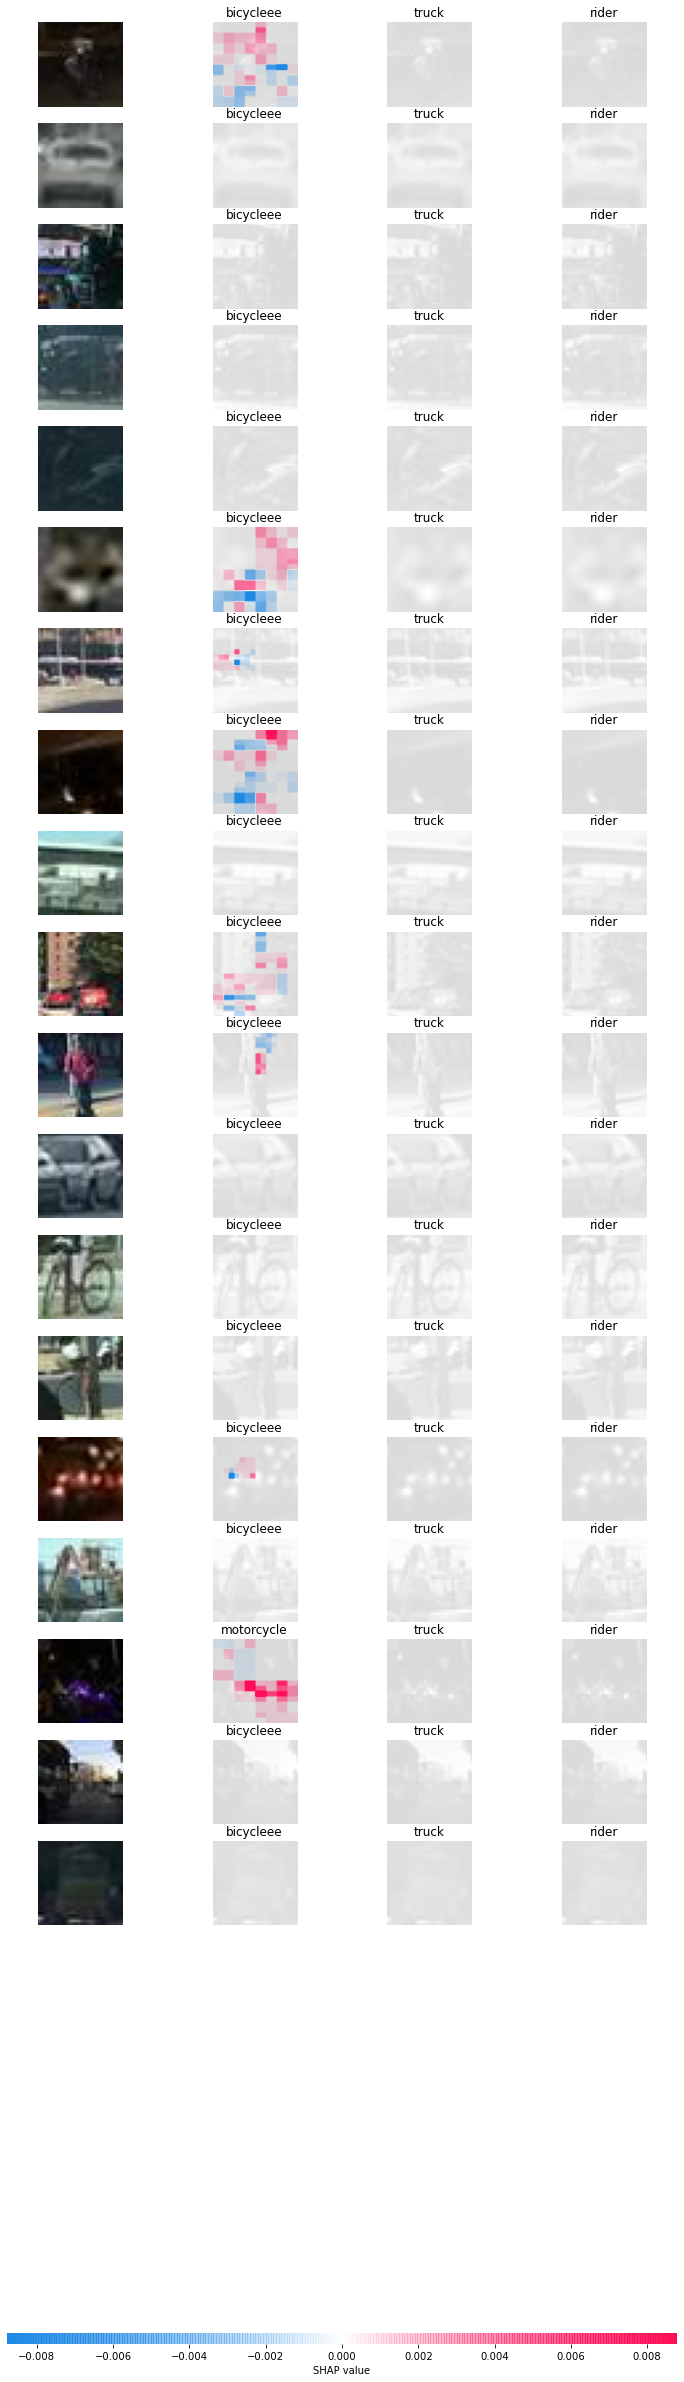

In [49]:
shap.image_plot(shap_valuesee)

In [32]:
model_path='save_models'
model_file='av11_ResNet44v1_model_no_mean.093.h5'

In [28]:
model=keras.models.load_model(os.path.join(model_path, model_file))

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________